
# Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a regression activity.

## Workflow
1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Data preparation, according to background information
    1. Set the __target__ variable, according to background information
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [1]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.csv` file and show a short description

In [2]:
url = 'regression_example.csv'
sep = ','
df = pd.read_csv(url, sep=sep)
df.head()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
0,0,1.509081,-1.049118,1.978885,1.060733,NaN,0.824655,0.819409,-1.157708,214.593802
1,1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189


## Data Exploration and preparation

##### Show a short description of the columns

In [3]:
df.describe()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
count,843.000000,802.000000,807.000000,812.000000,8.020000e+02,805.000000,808.000000,806.000000,812.000000,813.000000
mean,421.000000,-0.037473,0.008466,-0.059965,9.616777e-01,-0.093113,0.034653,-0.019928,-0.034976,3.798356
std,243.497433,1.038115,0.973884,0.991280,1.286476e+00,1.050385,0.957238,0.997345,0.963010,114.189124
min,0.000000,-3.700229,-2.832440,-4.141473,2.007427e-08,-4.072767,-2.968219,-2.850505,-3.948627,-358.659591
25%,210.500000,-0.723630,-0.640017,-0.681924,8.725649e-02,-0.802553,-0.625219,-0.689671,-0.662887,-73.823652
50%,421.000000,-0.032953,0.005693,-0.050789,4.707895e-01,-0.090512,0.051123,-0.014592,-0.049392,-0.159154
75%,631.500000,0.629368,0.681480,0.587393,1.350123e+00,0.611545,0.689203,0.612939,0.614423,75.487094
max,842.000000,3.043062,2.945731,2.925432,9.200073e+00,3.024952,3.210373,2.861549,3.000174,422.794685


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [14]:
rows_with_null = df[df.isnull().any(axis=1)]
print(len(rows_with_null))

273


#### Drop data that are useless or not usable

In [15]:
df = df.dropna()
df = df.drop('idx', axis=1)
print(f'Shape of the final dataset {df.shape[0]} rows and {df.shape[1]} columns')

Shape of the final dataset 570 rows and 9 columns


In [16]:
df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,response
1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189
5,-0.635465,-1.112850,-0.330580,6.141348,1.914527,0.408895,-0.364722,-0.731382,-261.116572


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [17]:
from sklearn.model_selection import train_test_split


target = 'response'
X = df.drop(target, axis=1)
y = df[target]

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

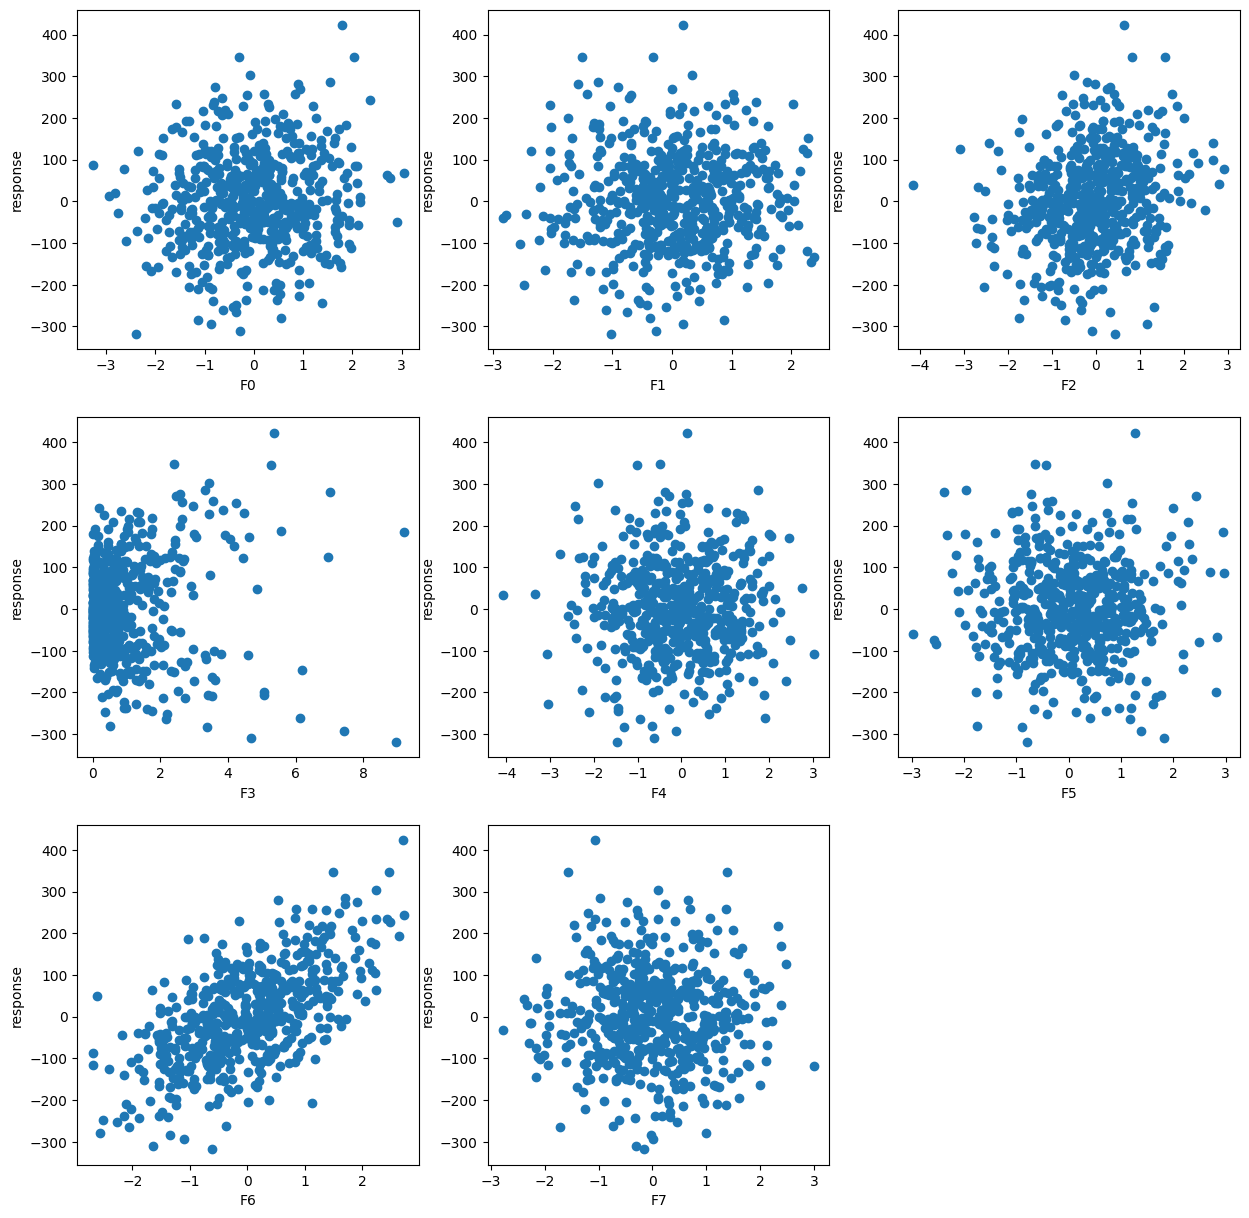

In [26]:
#define the size of the matrix of the subplots
n_cols = 3
n_rows = 3
#or you could calculate n_rows in a more precise way which would be n_rows = math.ceil(df.shape[1])-1/n_cols))

pos = 1
plt.figure(figsize=(15, 15))
for i in X.columns:
    plt.subplot(n_rows, n_cols, pos)
    plt.scatter(X[i], y)
    plt.xlabel(f'{i}')
    plt.ylabel(f'{target}')
    pos = pos+1

<Axes: >

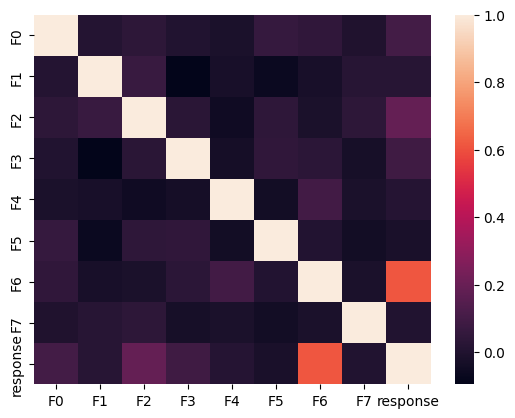

In [28]:
correlation_matrix = df.corr()
import seaborn as sns
sns.heatmap(correlation_matrix)

## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.7)
print(f'Training set and test set have {X_train.shape[0]} and {X_test.shape[0]} elements respectively')

Training set and test set have 399 and 171 elements respectively


## 2. First experiment - univariate linear regression
We choose the variable exhibiting the highest correlation with respect to the target

Consider a reduced dataset containing the chosen variable and the target

In [33]:
pred_var = 'F6'
X_train_r = X_train[pred_var].values.reshape(-1,1)
X_test_r = X_test[pred_var].values.reshape(-1,1)

#now let's create a dataframe containing the results to show everything afterwards
results = pd.DataFrame(columns=['Model', 'RMSE', 'R_square'])

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [32]:
estimator_1 = linear_model.LinearRegression()
estimator_1.fit(X_train_r, y_train)
y_pred_1 = estimator_1.predict(X_test_r)

#### Compute the quality measures

In [34]:
#the quality measures to be computed are
coeff_uni = estimator_1.coef_[0]
rmse_uni = mean_squared_error(y_test, y_pred_1, squared=False)
r2_uni = r2_score(y_test, y_pred_1)
results.loc[-1] = [f'linear univariate model on {y_pred_1}', rmse_uni,r2_uni]

## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [36]:
estimator_2 = linear_model.LinearRegression()
estimator_2.fit(X_train, y_train)
y_pred_2 = estimator_2.predict(X_test)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [37]:
pd.DataFrame({'Variable': X.columns, 'Coefficient': estimator_2.coef_})

,Variable,Coefficient
0,F0,9.225329
1,F1,2.794846
2,F2,21.766171
3,F3,3.299594
4,F4,-5.532386
5,F5,-6.002884
6,F6,72.949625
7,F7,-2.675824


#### Compute the quality measures

In [40]:
coeff_uni_2 = estimator_2.coef_[0]
rmse_2 = mean_squared_error(y_test, y_pred_2)
r2_score_2 = r2_score(y_test, y_pred_2)
results.loc[-1] = [f'Linear Multivariate ', rmse_2, r2_score_2]

## Decision Tree Multivariate Regresson

In [41]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [43]:
estimator_3 = DecisionTreeRegressor()
estimator_3.fit(X_train, y_train)
y_pred_3 = estimator_3.predict(X_test)
print(f'The maximum depth of the full Decision Tree Regressor is {estimator_3.tree_.max_depth}')

The maximum depth of the full Decision Tree Regressor is 22


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [44]:
from sklearn.model_selection import GridSearchCV


In [45]:
param_grid = {'max_depth': list(range(1, estimator_3.tree_.max_depth))}
tree_gscv = GridSearchCV(estimator=DecisionTreeRegressor(random_state=random_state)
                    , param_grid=param_grid
                    , scoring='neg_mean_squared_error' # select model with minimum mse
                    )
tree_gscv.fit(X_train, y_train)
tree_best = tree_gscv.best_estimator_
best_max_depth = tree_best.tree_.max_depth
print("The optimal maximum depth for the decision tree is {}".format(best_max_depth))

y_pred_tree = estimator_3.predict(X_test)
rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)
print(rmse_tree)
results.loc[len(results)] = ['Tree Regressor', rmse_tree, np.nan]

The optimal maximum depth for the decision tree is 2
113.41398522690814


#### Show the tree

[Text(0.5, 0.8333333333333334, 'F6 <= 0.493\nsquared_error = 13809.026\nsamples = 399\nvalue = 0.479'),
 Text(0.25, 0.5, 'F6 <= -1.071\nsquared_error = 9807.563\nsamples = 282\nvalue = -38.248'),
 Text(0.125, 0.16666666666666666, 'squared_error = 8030.323\nsamples = 57\nvalue = -115.58'),
 Text(0.375, 0.16666666666666666, 'squared_error = 8359.033\nsamples = 225\nvalue = -18.658'),
 Text(0.75, 0.5, 'F6 <= 1.68\nsquared_error = 11125.64\nsamples = 117\nvalue = 93.823'),
 Text(0.625, 0.16666666666666666, 'squared_error = 8971.137\nsamples = 102\nvalue = 76.235'),
 Text(0.875, 0.16666666666666666, 'squared_error = 9369.573\nsamples = 15\nvalue = 213.419')]

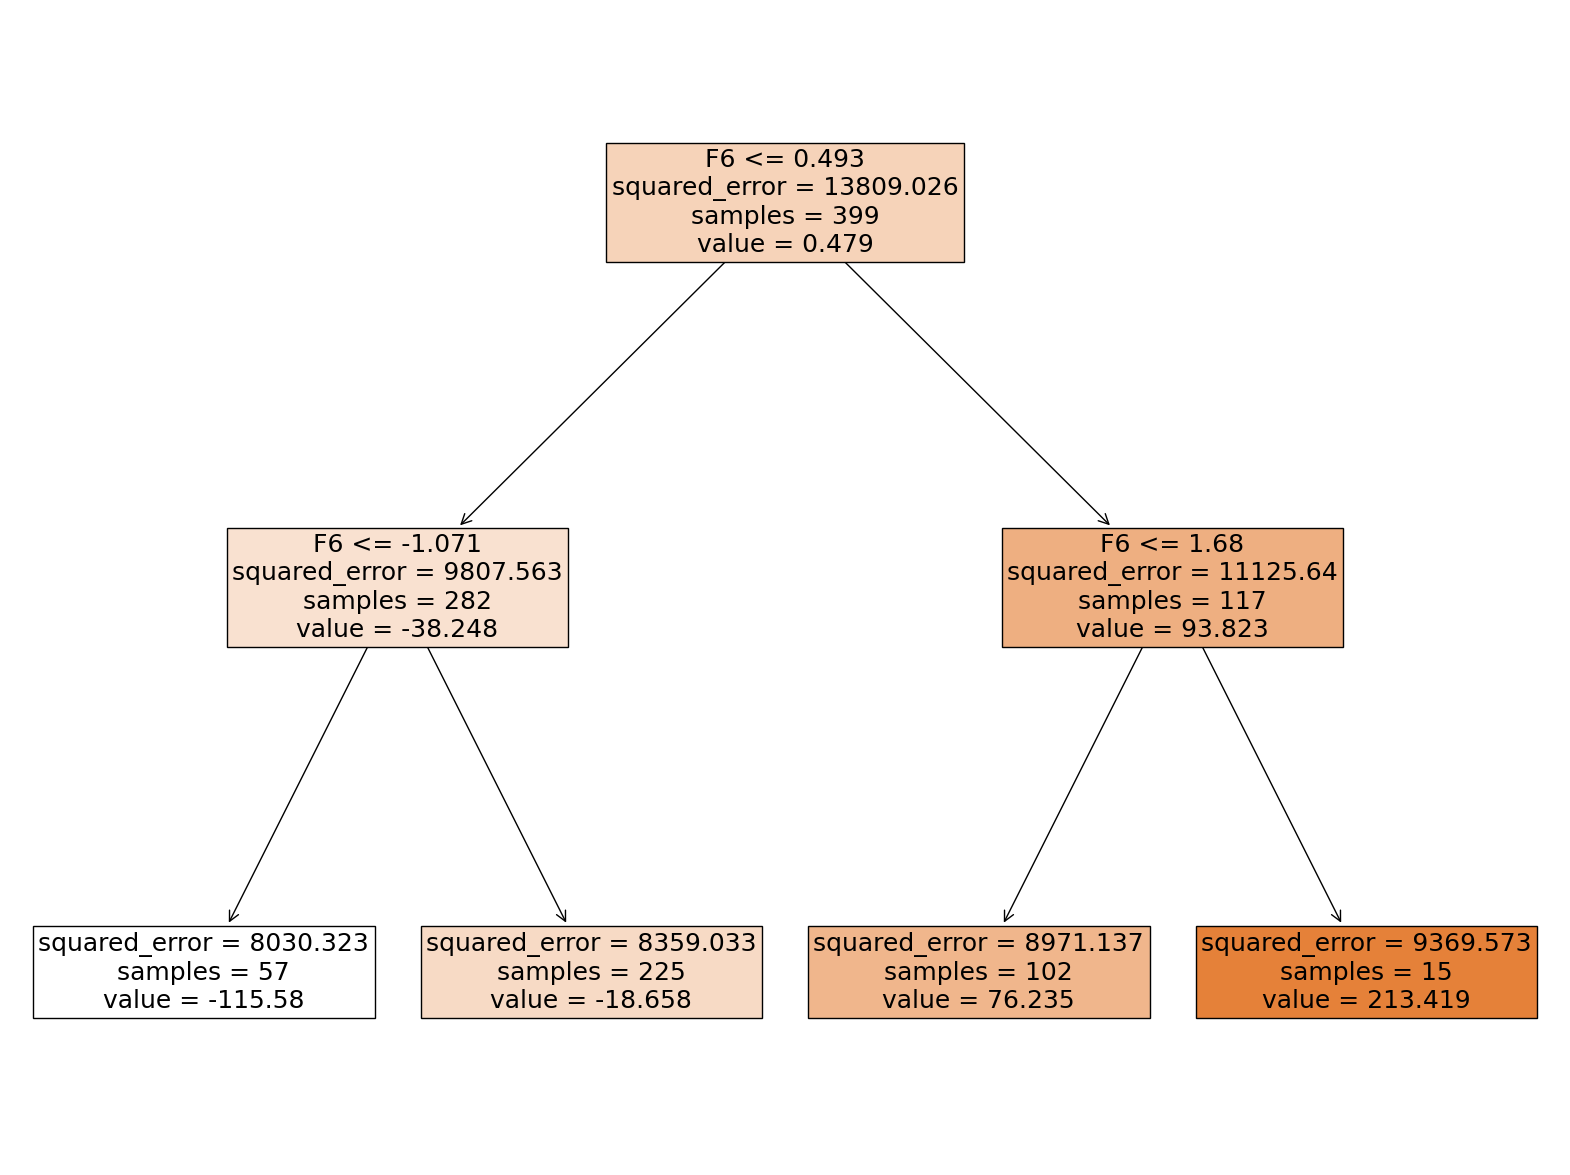

In [46]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
figure(figsize=(20, 15))
plot_tree(tree_best, filled=True, feature_names=X.columns.to_list(), max_depth=3, fontsize=18)

## Random Forest Multivariate Regresson

In [47]:
# Create Random Forest regression object
from sklearn.ensemble import RandomForestRegressor


In [50]:
rf = RandomForestRegressor(random_state=random_state)
param_grid_rf = {'max_depth': list(range(1, estimator_3.tree_.max_depth))}
rf_gscv = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_mean_squared_error')
rf_gscv.fit(X_train, y_train)

rf = rf_gscv.best_estimator_
print(f"The optimal maximum depth for the trees in the random forest is {rf.max_depth}")

The optimal maximum depth for the trees in the random forest is 3


In [26]:
y_pred_test_rf = rf.predict(X_test)
rmse_rf = mean_squared_error(y_test,y_pred_test_rf, squared=False)

print(f"Random Forest Regression - RMSE = {rmse_rf.round(2)}")
results.loc[len(results)] = ['Random Forest Regressor', rmse_rf, np.nan]

Random Forest Regression - RMSE = 84.70


### Plot the prediction of every model, compare it with the real test set, and print the metrics $R^2$ and RMSE 

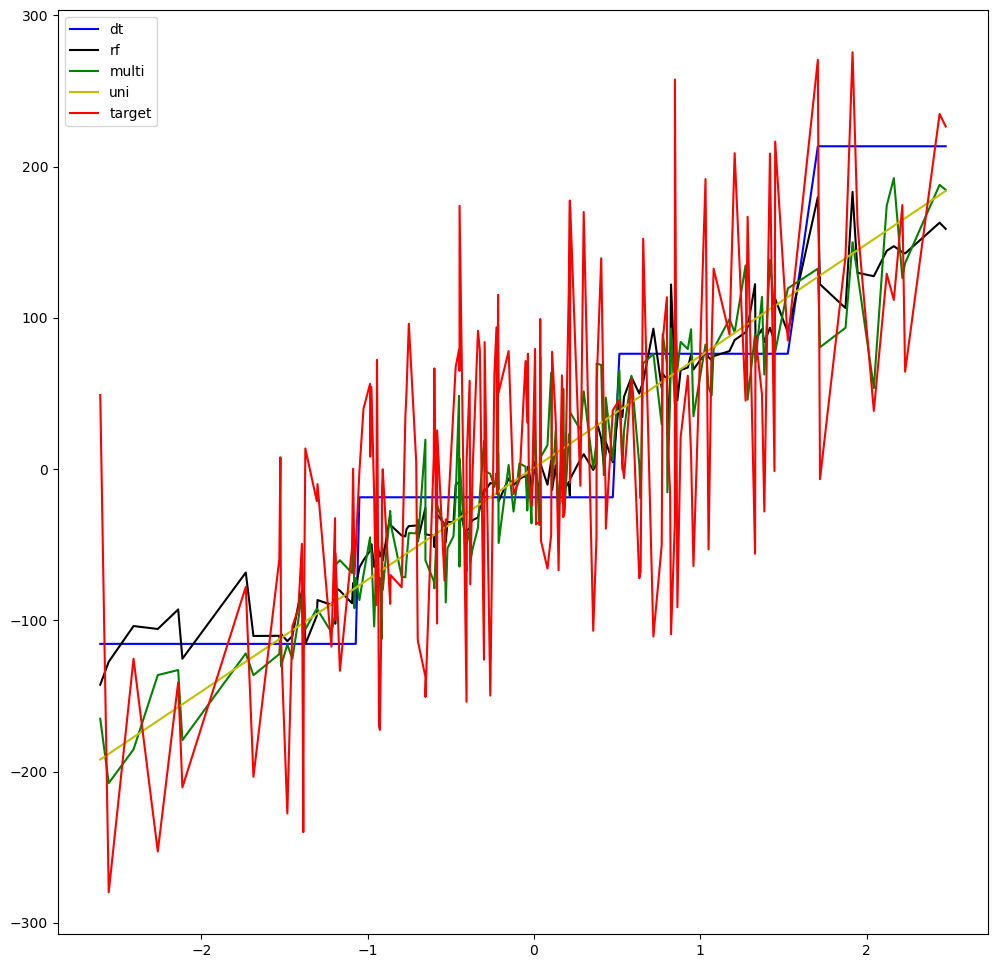

In [29]:
df_test_sorted=X_test
df_test_sorted['y_pred_dt']=y_pred_tree
df_test_sorted['y_pred_multi']=y_pred_2
df_test_sorted['y_pred_uni']=y_pred_1
df_test_sorted['y_pred_rf']=y_pred_test_rf
df_test_sorted[target]=y_test
df_test_sorted = df_test_sorted.sort_values(by=pred_var)


plt.figure(figsize=(12,12))
plt.plot(df_test_sorted[pred_var],df_test_sorted['y_pred_dt'], c='b');
plt.plot(df_test_sorted[pred_var],df_test_sorted['y_pred_rf'], c='k');
plt.plot(df_test_sorted[pred_var],df_test_sorted['y_pred_multi'], c='g');
plt.plot(df_test_sorted[pred_var],df_test_sorted['y_pred_uni'], c='y');
plt.plot(df_test_sorted[pred_var],df_test_sorted[target], c='r');
plt.legend(labels=['dt','rf','multi','uni','target'])
plt.show()

In [30]:
results.style.format(precision=3)

,Model,RMSE,R_square
0,Linear Univariate on F6,85.122,0.338
1,Linear Multivariate,81.104,0.399
2,Decision Tree Regressor,89.827,nan
3,Random Forest Regressor,84.701,nan


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 

### Decision Tree and Random Forest regression
- Decision Tree and Random Forest have an RMSE slightly higher than multivariate linear regression



## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with other columns and comment the results